### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.class_weight import compute_sample_weight


import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

### Load Cleaned Data Set

In [2]:
train_data = pd.read_csv("..\\Data\\train_data_EDA_processed.csv", index_col=0)

In [3]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,22073,22074,22075,22076,22077,22078,22079,22080,22081,22082
Patient_Age,2.0,4.0,6.0,12.0,11.0,14.0,3.0,3.0,11.0,4.0,...,13.0,4.0,10.0,0.0,9.0,4.0,8.0,8.0,7.0,11.0
Mother_Gene,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,...,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes
Father_Gene,No,Yes,No,No,No,No,No,No,No,Yes,...,Yes,No,No,No,Yes,Yes,Yes,No,No,No
Maternal_Gene,Yes,No,No,Yes,NaN,Yes,Yes,Yes,Yes,Yes,...,No,NaN,Yes,Yes,Yes,Yes,No,Yes,Yes,No
Paternal_Gene,No,No,No,No,Yes,No,Yes,Yes,No,Yes,...,Yes,No,Yes,No,Yes,No,Yes,No,Yes,No
Blood_Cell,4.760603,4.910669,4.893297,4.70528,4.720703,5.103188,4.90108,4.964816,5.209058,4.752272,...,4.874635,4.789307,4.64386,4.931758,5.012599,5.258298,4.97422,5.18647,4.858543,4.738067
Mother_Age,NaN,NaN,41.0,21.0,32.0,NaN,NaN,40.0,45.0,44.0,...,44.0,35.0,49.0,NaN,47.0,35.0,NaN,35.0,19.0,32.0
Father_Age,NaN,23.0,22.0,NaN,NaN,NaN,63.0,NaN,44.0,42.0,...,62.0,51.0,NaN,50.0,NaN,64.0,56.0,51.0,NaN,62.0
Status,Alive,Deceased,Alive,Deceased,Alive,Deceased,Alive,Alive,Alive,Alive,...,Alive,Alive,Deceased,Alive,Deceased,Deceased,Alive,Deceased,Alive,Deceased
Respiratory_Rate,Normal (30-60),Tachypnea,Normal (30-60),Tachypnea,Tachypnea,NaN,Normal (30-60),Tachypnea,Tachypnea,Tachypnea,...,Tachypnea,Tachypnea,NaN,Normal (30-60),NaN,Normal (30-60),Normal (30-60),Tachypnea,Tachypnea,Normal (30-60)


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19915 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient_Age           18672 non-null  float64
 1   Mother_Gene           19915 non-null  object 
 2   Father_Gene           19652 non-null  object 
 3   Maternal_Gene         17510 non-null  object 
 4   Paternal_Gene         19915 non-null  object 
 5   Blood_Cell            19915 non-null  float64
 6   Mother_Age            14719 non-null  float64
 7   Father_Age            14796 non-null  float64
 8   Status                19915 non-null  object 
 9   Respiratory_Rate      18058 non-null  object 
 10  Heart_Rate            18127 non-null  object 
 11  Follow_Up             18070 non-null  object 
 12  Gender                12008 non-null  object 
 13  Birth_Asphyxia        9060 non-null   object 
 14  Autopsy_Birth_Defect  9013 non-null   object 
 15  Birth_Place        

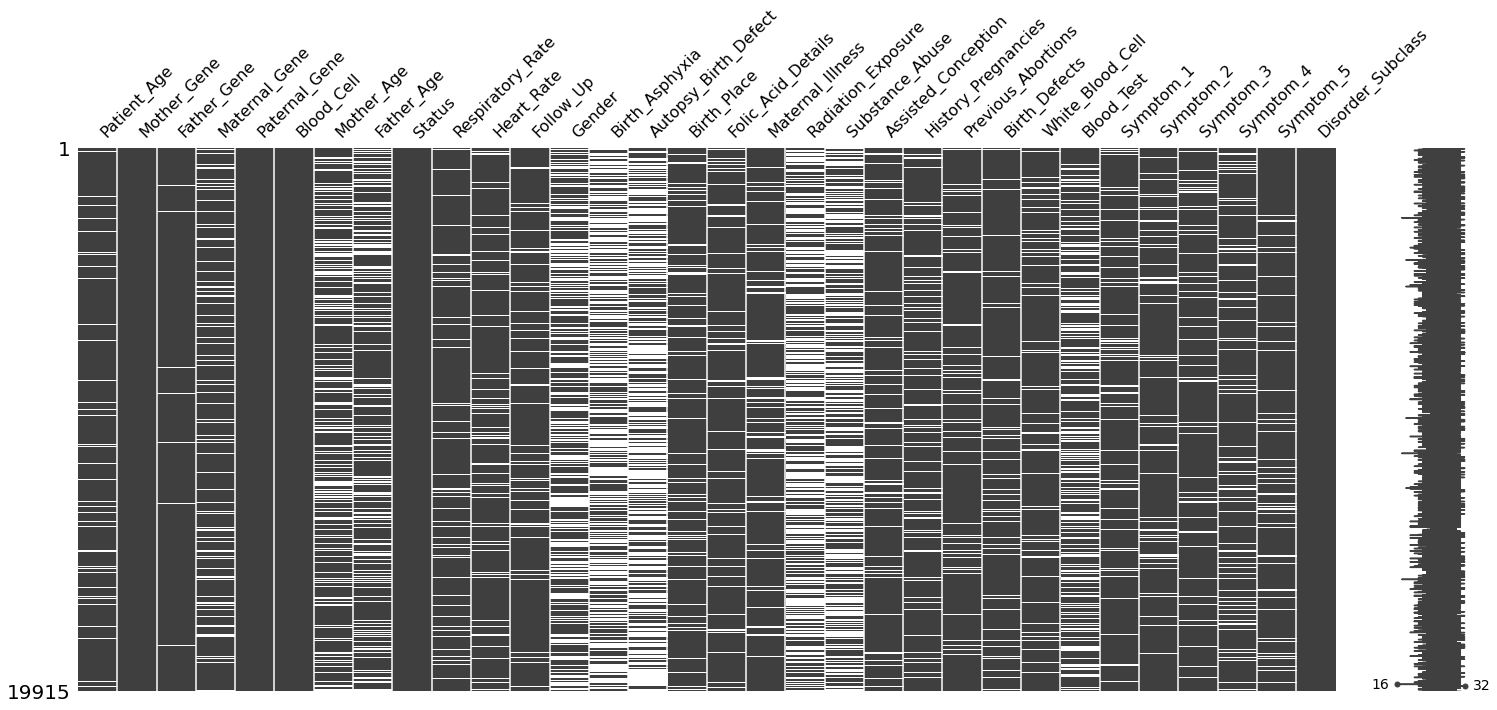

In [5]:
msno.matrix(train_data)
plt.show()

Leigh syndrome                         5160
Mitochondrial myopathy                 4405
Cystic fibrosis                        3448
Tay-Sachs                              2833
Diabetes                               1817
Hemochromatosis                        1355
Leber's hereditary optic neuropathy     648
Alzheimer's                             152
Cancer                                   97
Name: Disorder_Subclass, dtype: int64


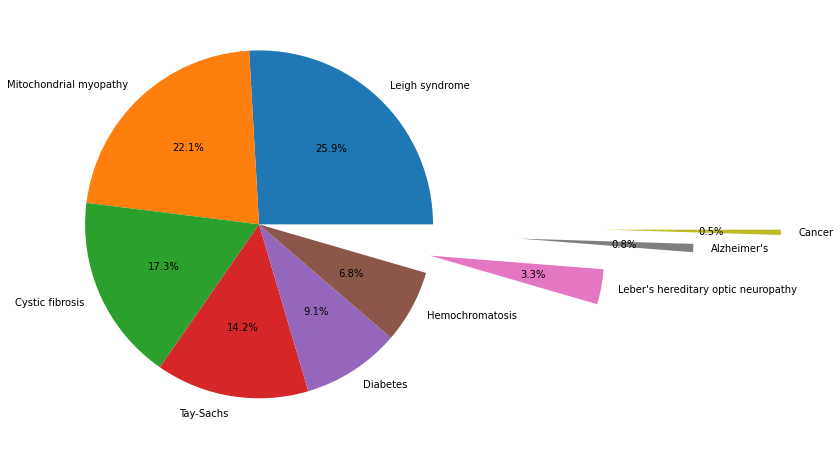

In [6]:
# Disorder Subclass Distribution
ds_counts = train_data.Disorder_Subclass.value_counts()
print(ds_counts)

plt.figure(figsize=(8,8))

mylab = ds_counts.index
explode = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1.5, 2)

plt.pie(ds_counts, labels=mylab, explode=explode, autopct='%1.1f%%')
plt.show()

### Road-Map Preprocessing 

Given the large amounts of missing data within certain columns and the misrepresentation effect that a mean or median imputation would have on the data when identifying disorder subclasses, I decided to go with constant imputation. Using constant imputation and creating missing values as its own catagorical group, I will have the model decide what information the missing values will be able to provide when classifying. Thus I will look into RandomForestClassifier, GradientBoostingClassifier and XGBoost, since they all use tree based modeling which are able to split on constant imputed missing values. These model algorithms also do not care and actually performs better without OneHotEncoding. This way, I will be able to keep track of my features.

### Preprocessing Pipeline

In [7]:
# Split the data into feature X and target y
X = train_data.drop(columns="Disorder_Subclass")
y = train_data.Disorder_Subclass

# Label encode target y
le = LabelEncoder()
encoded_y = le.fit_transform(y)

In [8]:
# Train Test Split by 20%
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.2, random_state=123)

In [9]:
# Grouped numerical columns
num_cols = train_data.select_dtypes('float64').columns

# Grouped categorical columns
cat_cols = train_data.select_dtypes('object').drop(columns="Disorder_Subclass").columns

# Preprocessing for numerical data
num_preprocessor = SimpleImputer(strategy='constant', fill_value=-99)

# Preprocessing for categorical data
cat_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="-99")),
                                   ('oe', OrdinalEncoder())])

# Combine num and cat preprocessor for data frame transformation
preprocessor = ColumnTransformer(
    transformers=[('num_transformer', num_preprocessor, num_cols),
                  ('cat_transformer', cat_preprocessor, cat_cols)])

In [10]:
# Preprocessor Test
feature_col_names = train_data.drop(columns="Disorder_Subclass").columns
preprocessed_df = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
preprocessed_df.columns = feature_col_names
preprocessed_df.head()

,Patient_Age,Mother_Gene,Father_Gene,Maternal_Gene,Paternal_Gene,Blood_Cell,Mother_Age,Father_Age,Status,Respiratory_Rate,...,History_Pregnancies,Previous_Abortions,Birth_Defects,White_Blood_Cell,Blood_Test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,6.0,4.816182,23.0,32.0,4.0,5.321413,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,2.0,0.0
1,13.0,5.005324,28.0,44.0,-99.0,4.334729,1.0,1.0,1.0,-99.0,...,1.0,0.0,2.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0
2,10.0,4.712737,26.0,-99.0,-99.0,8.649998,1.0,0.0,0.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,13.0,5.095956,-99.0,36.0,-99.0,7.548971,1.0,1.0,0.0,1.0,...,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0
4,8.0,4.847835,28.0,56.0,4.0,6.962187,1.0,1.0,-99.0,1.0,...,0.0,2.0,1.0,2.0,2.0,0.0,2.0,1.0,2.0,1.0


In [11]:
pd.DataFrame(preprocessor.fit_transform(X_train, y_train)).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15932 entries, 0 to 15931
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       15932 non-null  float64
 1   1       15932 non-null  float64
 2   2       15932 non-null  float64
 3   3       15932 non-null  float64
 4   4       15932 non-null  float64
 5   5       15932 non-null  float64
 6   6       15932 non-null  float64
 7   7       15932 non-null  float64
 8   8       15932 non-null  float64
 9   9       15932 non-null  float64
 10  10      15932 non-null  float64
 11  11      15932 non-null  float64
 12  12      15932 non-null  float64
 13  13      15932 non-null  float64
 14  14      15932 non-null  float64
 15  15      15932 non-null  float64
 16  16      15932 non-null  float64
 17  17      15932 non-null  float64
 18  18      15932 non-null  float64
 19  19      15932 non-null  float64
 20  20      15932 non-null  float64
 21  21      15932 non-null  float64
 22

### Baseline Model Comparisons

In [12]:
# RandomForestClassifier
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('randomforest', RandomForestClassifier(random_state=123))])

pipe_rf.fit(X_train, y_train)

pred_tr = pipe_rf.predict(X_train)
pred_te = pipe_rf.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

100.0
37.98644238011549
Scores: [37.05679322 37.02541575 38.07281858 36.47206529 38.63779033]
Mean: 37.45297663471601
Standard Deviation: 0.007861226644058908


In [13]:
# GradientBoostingClassifier
pipe_gb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('gradientboosting', GradientBoostingClassifier(random_state=123))])

pipe_gb.fit(X_train, y_train)

pred_tr = pipe_gb.predict(X_train)
pred_te = pipe_gb.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_gb, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

48.70700477027366
40.321365804669846
Scores: [41.5123941  40.25729526 41.9648462  39.04582549 40.20715631]
Mean: 40.597503472105274
Standard Deviation: 0.01037542106070992


In [14]:
# XGBClassifier
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgboost', xgb.XGBClassifier(random_state=123))])

pipe_xgb.fit(X_train, y_train)

pred_tr = pipe_xgb.predict(X_train)
pred_te = pipe_xgb.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

scores = cross_val_score(pipe_xgb, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

[09:26:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
95.93899071051972
36.75621390911373
[09:26:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:26:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:26:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in X

Evaluating on the cross validated mean scores for each model, the GradientBoostingClassifier had the highest score with 40.6, but looking at its training score, it performed poorly at 48.7. For both the RandomForestClassifier and XGBClassifier, both have really high train score, showing that there is overfitting that can be regularized. But the XGBoost performed slightly better than the RandomForest.
I will be following through with XGBoost since it can deal well with imbalanced classes in my data set, as well being robust in modeling large amounts of missing data.

### Defining XGB Baseline Model

In [32]:
# Default parameters set to multi-classification
params = {
    'objective':'multi:softmax',
    'eval_metric':'mlogloss',
    'seed':123
}

In [28]:
# Model without class weights
pipe_initial_noweights = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('xgboost', xgb.XGBClassifier(**params))])

pipe_initial_noweights.fit(X_train, y_train)

pred_tr = pipe_initial_noweights.predict(X_train)
pred_te = pipe_initial_noweights.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

95.93899071051972
36.75621390911373


In [29]:
# Cross Validation Score
scores = cross_val_score(pipe_initial_noweights, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [37.15092564 37.6215877  39.98744507 37.22536095 36.34651601]
Mean: 37.66636707386469
Standard Deviation: 0.012321997709810498


In [30]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.44      0.14      0.21        29
           1       0.80      0.17      0.29        23
           2       0.41      0.51      0.45       647
           3       0.35      0.26      0.30       346
           4       0.38      0.26      0.31       266
           5       0.29      0.15      0.20       126
           6       0.40      0.42      0.41      1072
           7       0.34      0.37      0.35       901
           8       0.31      0.29      0.30       573

    accuracy                           0.37      3983
   macro avg       0.41      0.29      0.31      3983
weighted avg       0.37      0.37      0.36      3983



In [31]:
# Adding Class Weight due to heavy imbalance of dataset seen in the EDA
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
sample_weights

array([ 1.20341416,  0.63199651,  1.62554841, ..., 14.39205059,
        0.43302892,  0.78328417])

In [33]:
# Model with class weights
pipe_initial = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgboost', xgb.XGBClassifier(**params))])

pipe_initial.fit(X_train, y_train, xgboost__sample_weight=sample_weights)

pred_tr = pipe_initial.predict(X_train)
pred_te = pipe_initial.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

92.58096911875471
35.32513181019332


In [34]:
# Cross Validation Score
scores = cross_val_score(pipe_initial, X_train, y_train, cv=5, scoring="accuracy", fit_params={'xgboost__sample_weight':sample_weights})
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [36.52337622 35.55067462 37.00564972 35.65599498 35.02824859]
Mean: 35.952788822923324
Standard Deviation: 0.007125507848876233


In [149]:
# Cross Validation Score for F1_Macro Score Metric baseline
scores = cross_val_score(pipe_initial, X_train, y_train, cv=5, scoring="f1_macro", fit_params={'xgboost__sample_weight':sample_weights})
print("F1_Macro Scores:", scores * 100)
print("F1_Macro Scores Mean:", scores.mean() * 100)
print("F1_Macro Scores Standard Deviation:", scores.std())

F1_Macro Scores: [30.26678641 30.39427911 29.76856274 28.50813865 31.21638715]
F1_Macro Scores Mean: 30.030830810700586
F1_Macro Scores Standard Deviation: 0.00892265599345136


In [35]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.24      0.14      0.17        29
           1       0.18      0.09      0.12        23
           2       0.39      0.48      0.43       647
           3       0.30      0.30      0.30       346
           4       0.29      0.36      0.32       266
           5       0.23      0.19      0.21       126
           6       0.42      0.34      0.38      1072
           7       0.36      0.33      0.34       901
           8       0.30      0.35      0.32       573

    accuracy                           0.35      3983
   macro avg       0.30      0.29      0.29      3983
weighted avg       0.36      0.35      0.35      3983



In [36]:
for i, val in enumerate(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])):
    print(i, val)

0 Alzheimer's
1 Cancer
2 Cystic fibrosis
3 Diabetes
4 Hemochromatosis
5 Leber's hereditary optic neuropathy
6 Leigh syndrome
7 Mitochondrial myopathy
8 Tay-Sachs


The initial model without class weights performs slightly better then the model with class weights. But the slight decrease to account for class_weights will hopefully lead to better learning model with tuning parameters to appropriately classify the small classes. The default parameters for XGBoost looks to be overfitting given then high 93-96 accuracy score for the train split, but only a 35-37 for the test split. This is supported by the cross validation with similar mean scores. Hyperparameter tuning will hopefully reduce the overfitting and increase the accuracy on the test split.

### Random Search and Grid Search with CV Functions

In [120]:
def rand_search_eval(hype_params):
    
    """
    Function performs RandomizedSearchCV on inputted hyper parameters.
    After models are created, the mean score and standard deviation of each iteration is stored.
    The model is graphed against F1_Macro score.
    The top 5 models are listed with their scores and iteration number for identification
    Best parameters and best score are printed too.
    """
    
    # Random Search with CV of the hyper parameters
    rand_search = RandomizedSearchCV(
        estimator=pipe_tuning,
        param_distributions=hype_params,
        scoring = 'f1_macro',
        n_iter = 20,
        cv = 5,
        verbose=True,
        random_state=123
    )
    
    # Fit and CV models with hyper parameters
    rand_search.fit(X_train, y_train, xgb_model__sample_weight=sample_weights)
    
    # Mean and Standard Deviation from iteration
    mean_score = list(rand_search.cv_results_['mean_test_score'])
    stds_score = list(rand_search.cv_results_['std_test_score'])
    
    # Graphs each iteration and its F1_Macro score
    plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
    plt.title("Rand_Search Iteration vs F1_Macro Score")
    plt.xlabel("Iteration")
    plt.ylabel("f1_score")
    plt.show()
    
    # Prints the top 5 scores with iteration number
    print(sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5])
    
    print("Best Parameters: ", rand_search.best_params_)
    print("Best Score: ", rand_search.best_score_)
    
    return(rand_search)

In [121]:
def grid_search_eval(hype_params):
    
    """
    Function performs GridSearchCV on inputted hyper parameters.
    After models are created, the mean score and standard deviation of each iteration is stored.
    The model is graphed against F1_Macro score.
    The top 5 models are listed with their scores and iteration number for identification
    Best parameters and best score are printed too.
    """
    
    # Grid Search with CV of the hyper parameters
    grid_search = GridSearchCV(
        estimator=pipe_tuning,
        param_grid=hype_params,
        scoring = 'f1_macro',
        cv = 5,
        verbose=True
    )
    
    # Fit and CV models with hyper parameters
    grid_search.fit(X_train, y_train, xgb_model__sample_weight=sample_weights)
    
    # Mean and Standard Deviation from iteration
    mean_score = list(grid_search.cv_results_['mean_test_score'])
    stds_score = list(grid_search.cv_results_['std_test_score'])
    
    # Graphs each iteration and its F1_Macro score
    plt.errorbar(list(range(0,len(mean_score))), mean_score, yerr=stds_score)
    plt.title("Grid_Search Iteration vs F1_Macro Score")
    plt.xlabel("Iteration")
    plt.ylabel("f1_score")
    plt.show()
    
    # Prints the top 5 scores with iteration number
    print(sorted(list(enumerate(mean_score)), key=lambda x: x[1], reverse=True)[0:5])
    
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)
    
    return(grid_search)

### Hyperparameter Tuning

In [122]:
# Base model with weighted class for the imbalance data set to tune
pipe_tuning = Pipeline(steps=[('preprocessor', preprocessor),
                              ('xgb_model', xgb.XGBClassifier(**params))])

Initial parameter ranges were chosen based on articles about tuning parameters as a starting point.

#### learning_rate and n_estimators

In [123]:
# Finding initial learning_rate and n_estimators.
hype_params = {
    'xgb_model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
    'xgb_model__n_estimators': range(50, 1000, 50),
}

Fitting 5 folds for each of 20 candidates, totalling 100 fits


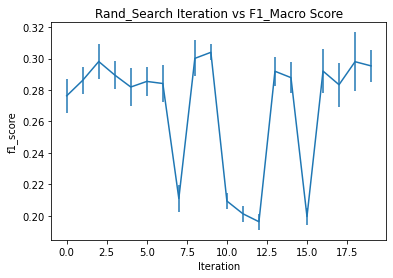

[(9, 0.3039368133030107), (8, 0.30008588750331533), (2, 0.2980943214843486), (18, 0.2979787110026922), (19, 0.2953164099505751)]
Best Parameters:  {'xgb_model__n_estimators': 50, 'xgb_model__learning_rate': 0.4}
Best Score:  0.3039368133030107


In [124]:
rand_search = rand_search_eval(hype_params)

In [125]:
selectList = [9, 8, 2, 18, 19]
modelParams = []

for i in selectList:
    print(i, rand_search.cv_results_['params'][i])
    modelParams.append(rand_search.cv_results_['params'][i])
    
x = [x['xgb_model__n_estimators'] for x in modelParams]
y = [x['xgb_model__learning_rate'] for x in modelParams]

9 {'xgb_model__n_estimators': 50, 'xgb_model__learning_rate': 0.4}
8 {'xgb_model__n_estimators': 150, 'xgb_model__learning_rate': 0.2}
2 {'xgb_model__n_estimators': 250, 'xgb_model__learning_rate': 0.1}
18 {'xgb_model__n_estimators': 850, 'xgb_model__learning_rate': 0.01}
19 {'xgb_model__n_estimators': 350, 'xgb_model__learning_rate': 0.1}


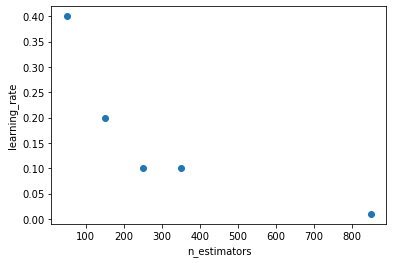

In [126]:
plt.scatter(x,y)
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

In [127]:
# Tuning the parameter range based on the top 3 rand_search results
hype_params = {
    'xgb_model__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.45],
    'xgb_model__n_estimators': range(30, 300, 25),
}

Fitting 5 folds for each of 66 candidates, totalling 330 fits


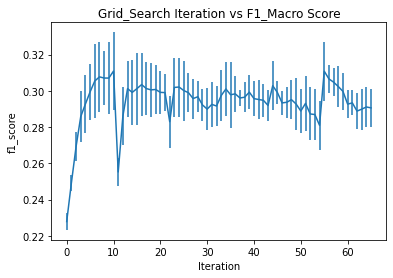

[(10, 0.31091839089782514), (55, 0.3108466659258959), (7, 0.3077107075290346), (8, 0.3070646893746959), (9, 0.3070489636930455)]
Best Parameters:  {'xgb_model__learning_rate': 0.05, 'xgb_model__n_estimators': 280}
Best Score:  0.31091839089782514


In [128]:
grid_search = grid_search_eval(hype_params)

In [129]:
grid_search.best_params_

{'xgb_model__learning_rate': 0.05, 'xgb_model__n_estimators': 280}

In [130]:
hype_params['xgb_model__learning_rate'] = [0.05]
hype_params['xgb_model__n_estimators'] = [280]
hype_params

{'xgb_model__learning_rate': [0.05], 'xgb_model__n_estimators': [280]}

Set the initial tuned parameters for learning_rate and n_estimators to the best identified parameters, and then continue with tuning the tree parameters. I will come back to the learning_rate and n_estimator one more time at the end of the optimization.

#### Tree Parameters: max_depth, min_child_weight, gamma

In [131]:
hype_params['xgb_model__max_depth'] = range(2, 22, 2)
hype_params['xgb_model__min_child_weight'] = range(1,16,2)
hype_params['xgb_model__gamma'] = range(0, 10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


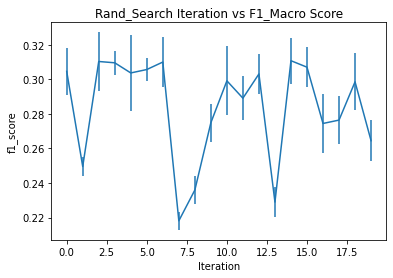

[(14, 0.31073351808265615), (2, 0.31028476340668476), (6, 0.3099592778668635), (3, 0.3095266958383372), (15, 0.30698830172456526)]
Best Parameters:  {'xgb_model__n_estimators': 280, 'xgb_model__min_child_weight': 11, 'xgb_model__max_depth': 10, 'xgb_model__learning_rate': 0.05, 'xgb_model__gamma': 1}
Best Score:  0.31073351808265615


In [132]:
rand_search = rand_search_eval(hype_params)

In [142]:
# Tuning the parameter range based on the top rand_search results
hype_params['xgb_model__max_depth'] = range(8, 13)
hype_params['xgb_model__min_child_weight'] = range(9,14)
hype_params['xgb_model__gamma'] = np.arange(0.8, 1.3, 0.1)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


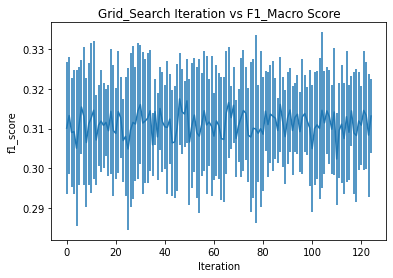

[(46, 0.317451096728259), (49, 0.31697280950377504), (66, 0.31653223704677613), (87, 0.31606739092693753), (30, 0.31602425580274224)]
Best Parameters:  {'xgb_model__gamma': 0.9, 'xgb_model__learning_rate': 0.05, 'xgb_model__max_depth': 12, 'xgb_model__min_child_weight': 10, 'xgb_model__n_estimators': 280}
Best Score:  0.317451096728259


In [143]:
grid_search = grid_search_eval(hype_params)

Given that the max_depth value is the highest value in the parameter search, I will perform a second round of grid_search with increased parameters.

In [147]:
hype_params['xgb_model__max_depth'] = range(10, 15)
hype_params['xgb_model__min_child_weight'] = range(8,13)
hype_params['xgb_model__gamma'] = np.arange(0.7, 1.2, 0.1)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


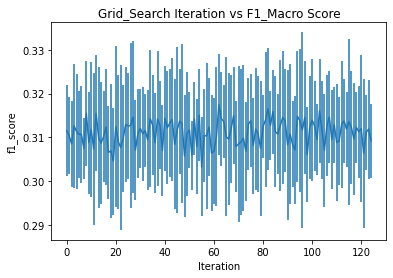

[(62, 0.317451096728259), (82, 0.31653223704677613), (103, 0.31606739092693753), (84, 0.31585418504564433), (12, 0.31548244622643745)]
Best Parameters:  {'xgb_model__gamma': 0.8999999999999999, 'xgb_model__learning_rate': 0.05, 'xgb_model__max_depth': 12, 'xgb_model__min_child_weight': 10, 'xgb_model__n_estimators': 280}
Best Score:  0.317451096728259


In [148]:
grid_search = grid_search_eval(hype_params)

In [150]:
# Set tuning parameters for found best parameters
hype_params['xgb_model__max_depth'] = [12]
hype_params['xgb_model__min_child_weight'] = [10]
hype_params['xgb_model__gamma'] = [0.9]

#### subsample and colsample_bytree

In [165]:
hype_params['xgb_model__subsample'] = [i/10.0 for i in range(0,11)]
hype_params['xgb_model__colsample_bytree'] = [i/10.0 for i in range(0,11)]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


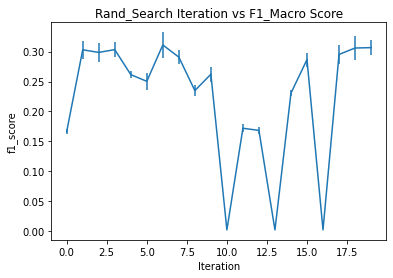

[(6, 0.3111158480552393), (19, 0.3066736515642691), (18, 0.3060233323782543), (3, 0.3033186209975073), (1, 0.3030298247606174)]
Best Parameters:  {'xgb_model__subsample': 1.0, 'xgb_model__n_estimators': 280, 'xgb_model__min_child_weight': 10, 'xgb_model__max_depth': 12, 'xgb_model__learning_rate': 0.05, 'xgb_model__gamma': 0.9, 'xgb_model__colsample_bytree': 0.7}
Best Score:  0.3111158480552393


In [166]:
rand_search = rand_search_eval(hype_params)

In [169]:
# Grid_Search parameters based on Rand_Search findings
hype_params['xgb_model__subsample'] = [0.7, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
hype_params['xgb_model__colsample_bytree'] = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

Fitting 5 folds for each of 63 candidates, totalling 315 fits


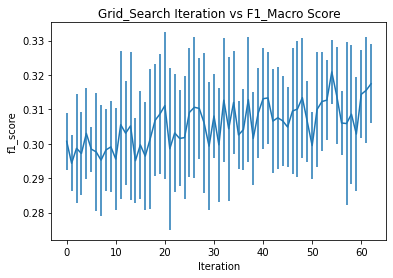

[(54, 0.32089004373102753), (62, 0.317451096728259), (61, 0.31553712757579466), (60, 0.3143723262084192), (55, 0.3139848532888326)]
Best Parameters:  {'xgb_model__colsample_bytree': 0.95, 'xgb_model__gamma': 0.9, 'xgb_model__learning_rate': 0.05, 'xgb_model__max_depth': 12, 'xgb_model__min_child_weight': 10, 'xgb_model__n_estimators': 280, 'xgb_model__subsample': 0.95}
Best Score:  0.32089004373102753


In [170]:
grid_search = grid_search_eval(hype_params)

In [172]:
# Set tuning parameters for found best parameters
hype_params['xgb_model__subsample'] = [0.95]
hype_params['xgb_model__colsample_bytree'] = [0.95]

{'xgb_model__learning_rate': [0.05],
 'xgb_model__n_estimators': [280],
 'xgb_model__max_depth': [12],
 'xgb_model__min_child_weight': [10],
 'xgb_model__gamma': [0.9],
 'xgb_model__subsample': [0.95],
 'xgb_model__colsample_bytree': [0.95]}

#### Tuning Regularization: reg_lambda and reg_alpha

I will be tuning lambda rather then alpha since the amount of features I have for my data is relatively small and does not need dimensional reduction.

In [174]:
hype_params['xgb_model__reg_lambda'] = [i/10.0 for i in range(7,16)]
hype_params['xgb_model__reg_alpha'] = [0, 0.001, 0.005, 0.01, 0.05]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


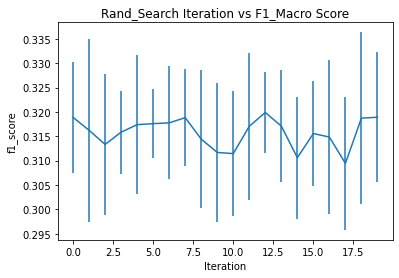

[(12, 0.3198800622567941), (19, 0.3189032355253613), (0, 0.3188761689601704), (7, 0.31882049830158055), (18, 0.31872312453829343)]
Best Parameters:  {'xgb_model__subsample': 0.95, 'xgb_model__reg_lambda': 1.0, 'xgb_model__reg_alpha': 0.001, 'xgb_model__n_estimators': 280, 'xgb_model__min_child_weight': 10, 'xgb_model__max_depth': 12, 'xgb_model__learning_rate': 0.05, 'xgb_model__gamma': 0.9, 'xgb_model__colsample_bytree': 0.95}
Best Score:  0.3198800622567941


In [175]:
rand_search = rand_search_eval(hype_params)

In [176]:
rand_search.cv_results_['params'][19]

{'xgb_model__subsample': 0.95,
 'xgb_model__reg_lambda': 1.4,
 'xgb_model__reg_alpha': 0,
 'xgb_model__n_estimators': 280,
 'xgb_model__min_child_weight': 10,
 'xgb_model__max_depth': 12,
 'xgb_model__learning_rate': 0.05,
 'xgb_model__gamma': 0.9,
 'xgb_model__colsample_bytree': 0.95}

In [179]:
# Tuning the parameter range based on the top rand_search results
hype_params['xgb_model__reg_lambda'] = [0.90, 0.95, 1, 1.05, 1.10]
hype_params['xgb_model__reg_alpha'] = [0, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01]

Fitting 5 folds for each of 35 candidates, totalling 175 fits


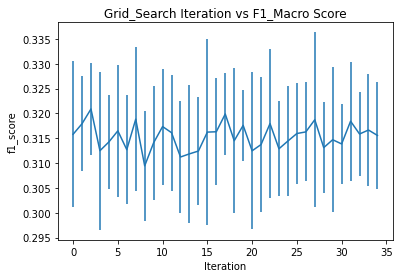

[(2, 0.32089004373102753), (17, 0.3198800622567941), (7, 0.3188385299427333), (27, 0.31872312453829343), (31, 0.31842644115493746)]
Best Parameters:  {'xgb_model__colsample_bytree': 0.95, 'xgb_model__gamma': 0.9, 'xgb_model__learning_rate': 0.05, 'xgb_model__max_depth': 12, 'xgb_model__min_child_weight': 10, 'xgb_model__n_estimators': 280, 'xgb_model__reg_alpha': 0, 'xgb_model__reg_lambda': 1, 'xgb_model__subsample': 0.95}
Best Score:  0.32089004373102753


In [180]:
grid_search = grid_search_eval(hype_params)

In [181]:
# Set tuning parameters for found best parameters
hype_params['xgb_model__reg_lambda'] = [1]
hype_params['xgb_model__reg_alpha'] = [0]

#### Checking back on learning_rate and n_estimator
I skipped this step in interest in time, I will perform this after our mentor meeting if it improves the metric.

After all other parameters have been set to optimal values, I am going to re-evaluate the learning_rate and n_estimator to see if there are impovements with deeper learning parameters. Lower value for learning_rate and higher value for n_estimator. I will be going straight to GridSearch given I have initial parameters and range to work with.

In [490]:
# hype_params['xgb_model__learning_rate'] = [0.001, 0.01, 0.03, 0.05, 0.1]
# hype_params['xgb_model__n_estimators'] = [270, 275, 280, 285, 290, 295, 300]

In [491]:
# grid_search = grid_search_eval(hype_params)

In [ ]:
# Set final learning_rate and n_estimator
# hype_params['xgb_model__learning_rate'] = []
# hype_params['xgb_model__n_estimators'] = []

#### Final Hyper Parameters

In [182]:
# Final hyper_parameters
hype_params

{'xgb_model__learning_rate': [0.05],
 'xgb_model__n_estimators': [280],
 'xgb_model__max_depth': [12],
 'xgb_model__min_child_weight': [10],
 'xgb_model__gamma': [0.9],
 'xgb_model__subsample': [0.95],
 'xgb_model__colsample_bytree': [0.95],
 'xgb_model__reg_lambda': [1],
 'xgb_model__reg_alpha': [0]}

### Final Model

In [183]:
final_model = xgb.XGBClassifier(objective='Multi:softmax', eval_metric="mlogloss", use_label_encoder=False, seed=123,
                                learning_rate=0.05,
                                n_estimators=280,
                                max_depth=12,
                                min_child_weight=10,
                                gamma=0.9,
                                colsample_bytree=0.95,
                                subsample=0.95,
                                reg_alpha=0,
                                reg_lambda=1)

pipe_final = Pipeline(steps=[('preprocessor', preprocessor),
                             ('xgb_model', final_model)])

pipe_final.fit(X_train, y_train, xgb_model__sample_weight=sample_weights)

pred_tr = pipe_final.predict(X_train)
pred_te = pipe_final.predict(X_test)

print(accuracy_score(y_train, pred_tr) * 100)
print(accuracy_score(y_test, pred_te) * 100)

93.3592769269395
36.279186542806926


In [184]:
# Cross Validation Score
scores = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [38.78255413 38.87668654 39.20276208 36.15819209 37.25674827]
Mean: 38.05538862268266
Standard Deviation: 0.011624927428611698


In [186]:
print(classification_report(y_test, pred_te))

              precision    recall  f1-score   support

           0       0.19      0.10      0.13        29
           1       0.27      0.26      0.27        23
           2       0.41      0.51      0.46       647
           3       0.31      0.31      0.31       346
           4       0.30      0.36      0.33       266
           5       0.24      0.21      0.22       126
           6       0.43      0.34      0.38      1072
           7       0.37      0.35      0.36       901
           8       0.30      0.34      0.32       573

    accuracy                           0.36      3983
   macro avg       0.31      0.31      0.31      3983
weighted avg       0.37      0.36      0.36      3983



# Do i fit using my weight class? or as is is appropriate as below

In [187]:
# Fit Final Model to Entire Training Data
pipe_final.fit(X, encoded_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  SimpleImputer(fill_value=-99,
                                                                strategy='constant'),
                                                  Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('im...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.05, max_delta_step=0,
                               max_depth=12, min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=280,
                        

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

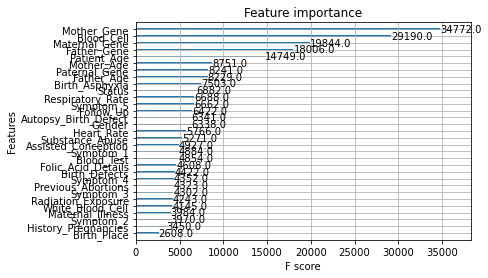

In [188]:
final_model.get_booster().feature_names = list(feature_col_names)
xgb.plot_importance(final_model.get_booster(), max_num_features=len(feature_col_names))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

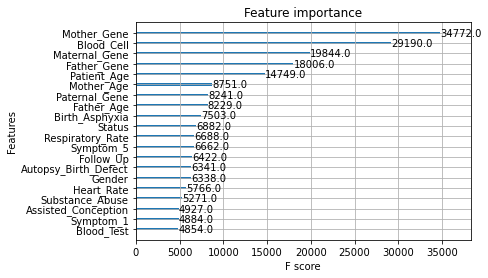

In [197]:
xgb.plot_importance(final_model.get_booster(), max_num_features=20)

### Kaggle Output Data and Final Model Testing

In [230]:
test_data = pd.read_csv("..\\Data\\test_data_cleaned.csv", index_col=0)
test_data_raw = pd.read_csv("..\\Data\\Raw Data\\test.csv")

output_df = pd.DataFrame(test_data_raw["Patient Id"])

In [231]:
Disorder_Subclass_Predictions = le.inverse_transform(pipe_final.predict(test_data))

In [232]:
Genetic_Disorder = []

for val in Disorder_Subclass_Predictions:
    if val == "Cystic fibrosis":
        Genetic_Disorder.append("Single-gene inheritance diseases")
    elif val == "Hemochromatosis":
        Genetic_Disorder.append("Single-gene inheritance diseases")
    elif val == "Tay-Sachs":
        Genetic_Disorder.append("Single-gene inheritance diseases")
    elif val == "Diabetes":
        Genetic_Disorder.append("Multifactorial genetic inheritance disorders")
    elif val == "Cancer":
        Genetic_Disorder.append("Multifactorial genetic inheritance disorders")
    elif val == "Alzheimer's":
        Genetic_Disorder.append("Multifactorial genetic inheritance disorders")
    else: Genetic_Disorder.append("Mitochondrial genetic inheritance disorders")

In [234]:
output_df["Genetic Disorder"] = Genetic_Disorder
output_df["Disorder Subclass"] = Disorder_Subclass_Predictions

output_df

,Patient Id,Genetic Disorder,Disorder Subclass
0,PID0x4175,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x21f5,Single-gene inheritance diseases,Hemochromatosis
2,PID0x49b8,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy
3,PID0x2d97,Single-gene inheritance diseases,Cystic fibrosis
4,PID0x58da,Single-gene inheritance diseases,Cystic fibrosis
...,...,...,...
9460,PID0x81e1,Single-gene inheritance diseases,Cystic fibrosis
9461,PID0x3514,Multifactorial genetic inheritance disorders,Diabetes
9462,PID0x5408,Single-gene inheritance diseases,Tay-Sachs
9463,PID0x2017,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy


In [235]:
output_df.to_csv('../Data/outputPredicted.csv')

### Follow Up

In [238]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe_final, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

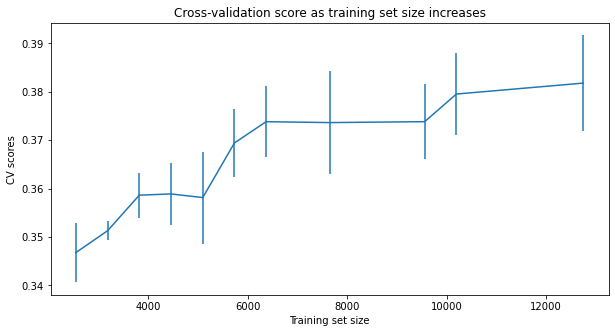

In [239]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');
plt.show()

In [ ]:
# Will write a bit more